In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import planar_manipulator
importlib.reload(planar_manipulator)
from planar_manipulator import PlanarManipulator


In [2]:
train_data = pd.read_csv('my_data.csv')
X_data_pd = train_data[['x2', 'y2']]
Y_data_pd = train_data[['q1', 'q2']]

X_data = X_data_pd.to_numpy()
Y_data = Y_data_pd.to_numpy()

q1_lim = np.array([-np.pi, np.pi])
q2_lim = np.array([-np.pi, np.pi])

robot = PlanarManipulator(1.0, 1.0, q1_lim, q2_lim)

In [3]:
from sklearn.model_selection import train_test_split

X_temp, X_test, Y_temp, Y_test = train_test_split(
    X_data, Y_data, test_size=0.15, random_state=42
)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp, test_size=0.176, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")   
print(f"Validation set size: {X_val.shape[0]}")         
print(f"Test set size: {X_test.shape[0]}")    


Training set size: 1751
Validation set size: 374
Test set size: 375


In [4]:
import tensorflow as tf

def forward_kinematics(q):
    L1 = 1.0
    L2 = 1.0
    q1 = q[:, 0]
    q2 = q[:, 1]
    x2 = L1 * tf.cos(q1) + L2 * tf.cos(q1 + q2)
    y2 = L1 * tf.sin(q1) + L2 * tf.sin(q1 + q2)
    return tf.stack([x2, y2], axis=1)

def cartesian_loss(y_true, y_pred):
    x2y2_pred = forward_kinematics(y_pred)
    return tf.reduce_mean(tf.square(y_true - x2y2_pred))

In [5]:
import tensorflow as tf
from keras.api.models import Sequential, load_model
from keras.api.layers import Dense
import os
import warnings
warnings.filterwarnings('ignore')

In [6]:
model_path = 'models\my_ik_model_50_50.keras'
if os.path.exists(model_path):
    model = load_model(
    model_path,
    custom_objects={'cartesian_loss': cartesian_loss}
)
else:
    model = Sequential([
        Dense(50, activation='relu', input_shape=(2,)),  # Input: x2, y2
        Dense(50, activation='relu'),
        Dense(2)  # Output: q1, q2 (linear)
    ])
    model.compile(optimizer='adam', loss=cartesian_loss)
    model.summary()

    history = model.fit(
        X_train, X_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, X_val)
    )
    model.save(model_path)

In [7]:
Y_pred = model.predict(X_test)

L1 = 1.0
L2 = 1.0

q1_pred = Y_pred[:,0]
q2_pred = Y_pred[:,1]

elbow, X_pred = robot.forward_kinematics(Y_pred)
x2_pred, y2_pred = X_pred[:, 0], X_pred[:, 1]

x2_true = X_test[:,0]
y2_true = X_test[:,1]


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [8]:
def count_out_of_bounds(q, q1_lim, q2_lim):
    q = np.atleast_2d(q)
    q1, q2 = q[:, 0], q[:, 1]
    valid_q1 = (q1_lim[0] <= q1) & (q1 <= q1_lim[1])
    valid_q2 = (q2_lim[0] <= q2) & (q2 <= q2_lim[1])
    valid_mask = valid_q1 & valid_q2

    total = len(valid_mask)
    invalid = np.sum(~valid_mask)
    print(f"Total samples: {total}")
    print(f"Out of bounds: {invalid} ({100 * invalid / total:.2f}%)")
    return None

count_out_of_bounds(Y_pred, q1_lim=[-np.pi/2, np.pi/2], q2_lim=[-np.pi/3, np.pi/3])

Total samples: 375
Out of bounds: 40 (10.67%)


Mean Cartesian error: 0.036213393749359495


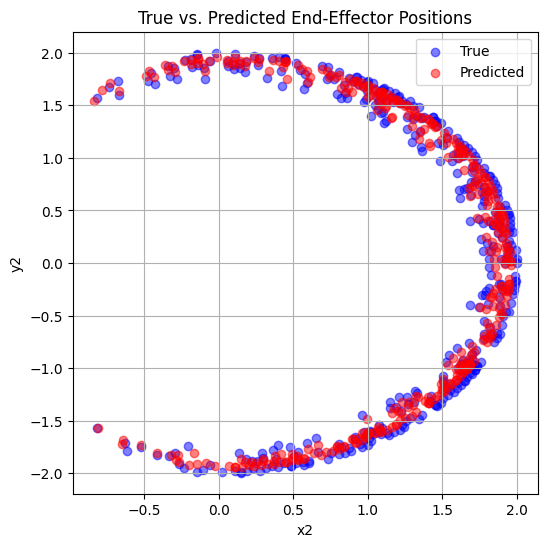

In [9]:
errors = np.sqrt((x2_true - x2_pred)**2 + (y2_true - y2_pred)**2)
print(f"Mean Cartesian error: {np.mean(errors)}")


plt.figure(figsize=(6,6))
plt.scatter(x2_true, y2_true, color='blue', alpha=0.5, label='True')
plt.scatter(x2_pred, y2_pred, color='red', alpha=0.5, label='Predicted')
plt.legend()
plt.xlabel('x2')
plt.ylabel('y2')
plt.title('True vs. Predicted End-Effector Positions')
plt.grid()
plt.show()

In [10]:
for i in range(6):
    print(f"Sample {i+1}:")
    print(f"  True joint angles (q1, q2):      {Y_test[i]}")
    print(f"  Predicted joint angles (q1, q2): {Y_pred[i]}")
    print(f"  True Cartesian (x2, y2):         {X_test[i]}")
    print(f"  Predicted Cartesian (x2, y2):    {X_pred[i]}")
    print()

Sample 1:
  True joint angles (q1, q2):      [1.44256806 0.14959965]
  Predicted joint angles (q1, q2): [1.3126664  0.40374964]
  True Cartesian (x2, y2):         [0.10650741 1.99156165]
  Predicted Cartesian (x2, y2):    [0.11016721 1.9562852 ]

Sample 2:
  True joint angles (q1, q2):      [-0.67319843 -0.10685689]
  Predicted joint angles (q1, q2): [-0.9796904   0.49425036]
  True Cartesian (x2, y2):         [ 1.49270611 -1.32680855]
  Predicted Cartesian (x2, y2):    [ 1.4417493 -1.2969224]

Sample 3:
  True joint angles (q1, q2):      [-0.67319843 -0.14959965]
  Predicted joint angles (q1, q2): [-1.0035956   0.49355876]
  True Cartesian (x2, y2):         [ 1.46200422 -1.35654167]
  Predicted Cartesian (x2, y2):    [ 1.4099997 -1.3316176]

Sample 4:
  True joint angles (q1, q2):      [0.8014267  0.87622652]
  Predicted joint angles (q1, q2): [0.8711591 0.7306276]
  True Cartesian (x2, y2):         [0.5890289  1.71264558]
  Predicted Cartesian (x2, y2):    [0.61295485 1.7645957 ]

Sa

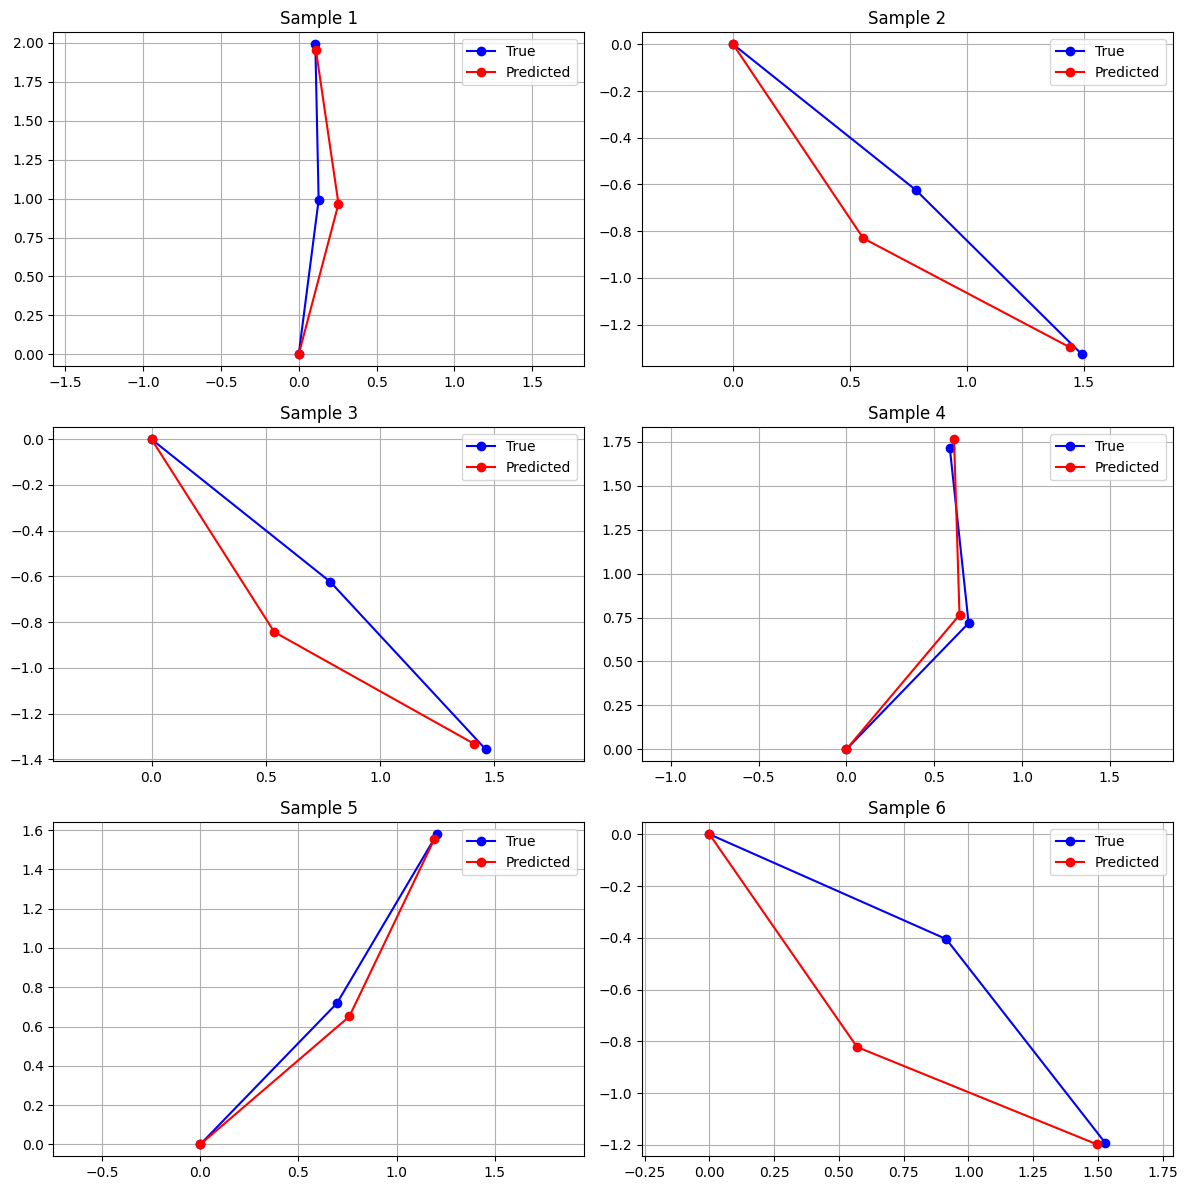

In [11]:
num_samples = 6
plt.figure(figsize=(12, 12))

for i in range(num_samples):
    plt.subplot(3, 2, i + 1)
    
    # True pose
    robot.plot(Y_test[i, 0], Y_test[i, 1], color='blue', label='True')
    
    # Predicted pose
    robot.plot(q1_pred[i], q2_pred[i], color='red', label='Predicted')
    
    plt.title(f'Sample {i + 1}')
    plt.axis('equal')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()
